# Sentiment Analysis

<center>  
<img src="https://miro.medium.com/v2/1*_JW1JaMpK_fVGld8pd1_JQ.gif">  
</center>  

**Sentiment Analysis** is the process of detecting and classifying **emotions or opinions** expressed through different types of data — including **text, speech, images, and videos** — to determine whether the sentiment is **positive, negative, or neutral**.

In this section, we’ll focus on **text-based sentiment analysis** and implement a **Multinomial Naive Bayes classifier** using the [IMDB Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).
The task is simple:

> Classify movie reviews as either **Positive** or **Negative** based on their content.

But before we dive into the model, let’s pause and ask:

### 🤔 Why Multinomial Naive Bayes?

Because it's perfect for **text data** where we count how often words appear.

Multinomial Naive Bayes works well when features are **word counts**, which is exactly what we get from text like reviews.

> Models like **Gaussian Naive Bayes** expect continuous numbers (like height or temperature), not word counts — so they don’t fit well for text tasks.


In [146]:
import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\regmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\regmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\regmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [147]:
df = pd.read_csv('./IMDB Dataset.csv/IMDB_Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## EDA


In [149]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Our dataset set is balanced. Next, let's take a look at the number of characters present in each sentence. This can give us a rough idea about movie's review.


<Axes: >

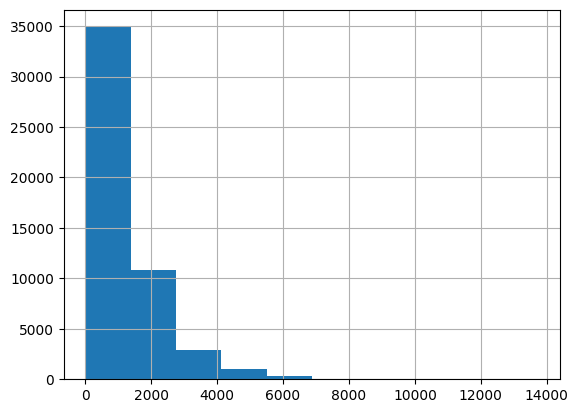

In [150]:
df['review'].str.len().hist()

The histogram shows that reviews range from 10 to 14000 characters and generally, it is between 10 to 1500 characters.

Now, let's move on the histogram for positive and negative reviews respectively.

Text(0.5, 1.0, 'Negative Reviews')

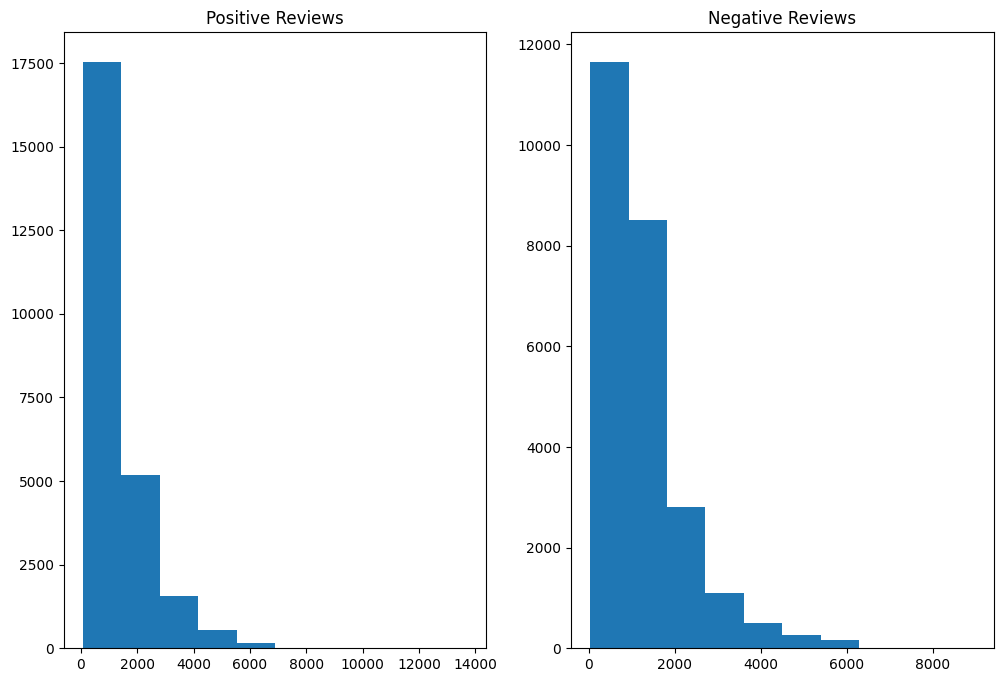

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

ax1.hist(df[df['sentiment']=='positive']['review'].str.len())
ax1.set_title( 'Positive Reviews')
ax2.hist(df[df['sentiment']=='negative']['review'].str.len())
ax2.set_title( 'Negative Reviews')

### 📊 Insights from the Graph

We can observe some interesting insights from the graph above:

* **Shorter Comments for Positive Reviews**:
  In general, people tend to write **fewer words** in positive reviews compared to negative ones.

* **Wider Range in Positive Review Lengths**:
  However, the **range** of word counts in positive reviews is **larger** than that in negative reviews.
  This suggests that:

  * Some users leave **very long comments** when they love a movie.
  * On the other hand, even when criticizing a bad movie, people may keep it **brief**.


### ☁️ WordCloud Visualization

Before we move on to the next section—**text data preprocessing**—
we will create **WordClouds** for both **positive** and **negative** reviews.

* The **most frequently used words** will appear in **larger fonts**.
* The **less frequently used words** will appear in **smaller fonts**.

This will help us visually understand which words are common in each sentiment class.

In [152]:
def wordCloud(label:str, title:str):
    text = " ".join(i for i in df[df['sentiment']==label]['review'])
    wordcloud = WordCloud( background_color="white").generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

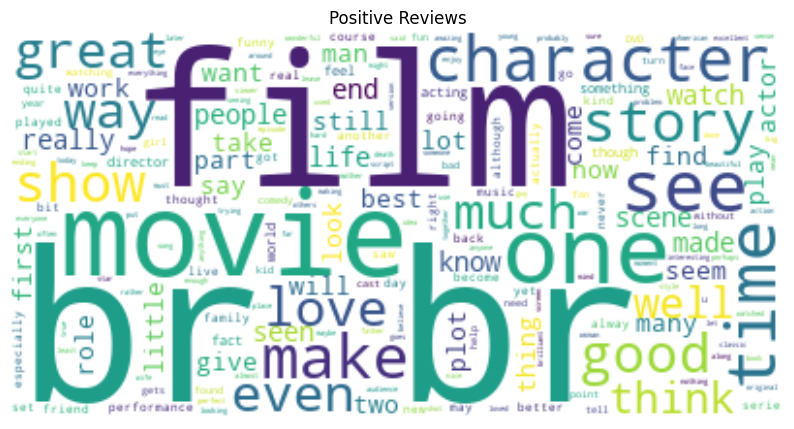

In [153]:
wordCloud('positive', 'Positive Reviews')

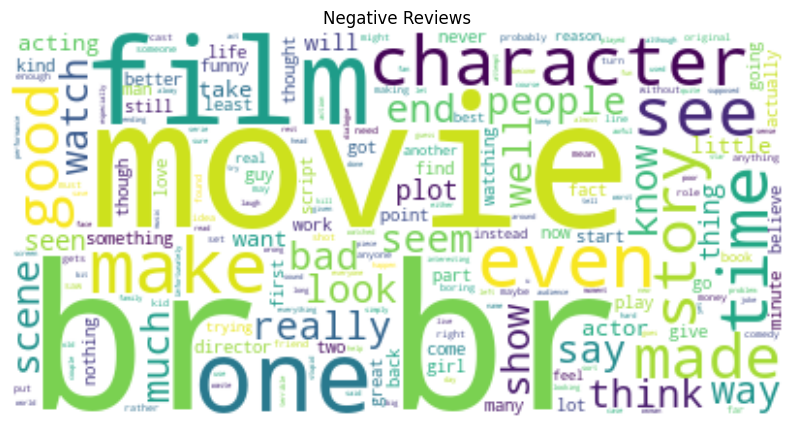

In [154]:
wordCloud('negative', 'Negative Reviews')

The wordcloud graphs in both negative and postitive comments don't show meaningful result.

That's is the reason why text preprosessing is needed.

### Preprocessing

In [155]:
df.rename(columns={'review':'text'}, inplace = True)
df.head()

,text,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1: Cleaning 
    - Converts text to lowercase.
    - Removes URLs, standalone numbers, and HTML tags.
    - Removes punctuation, newlines, and specific unicode punctuations.
    - Removes emojis using a regex pattern.
    - Expands common English contractions (e.g., "isn't" → "is not").
    - Removes extra whitespace.

In [156]:
import re
import string

def cleaning(text):
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove standalone numbers
    text = re.sub(r'\b\d+\b', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    # Remove newlines and specific unicode punctuations
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[’“”…]', '', text)

    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)

    # Expand contractions
    contractions = {
        "isn't": "is not", "he's": "he is", "wasn't": "was not", "there's": "there is",
        "couldn't": "could not", "won't": "will not", "they're": "they are", "she's": "she is",
        "wouldn't": "would not", "haven't": "have not", "that's": "that is", "you've": "you have",
        "what's": "what is", "weren't": "were not", "we're": "we are", "hasn't": "has not",
        "you'd": "you would", "shouldn't": "should not", "let's": "let us", "they've": "they have",
        "you'll": "you will", "i'm": "i am", "we've": "we have", "it's": "it is", "don't": "do not",
        "that´s": "that is", "i´m": "i am", "it’s": "it is", "she´s": "she is", "i’m": "i am",
        "i’d": "i did", "there’s": "there is"
    }

    for contraction, expanded in contractions.items():
        text = re.sub(rf"\b{re.escape(contraction)}\b", expanded, text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [157]:
data = df['text'].apply(cleaning)
data.sample(5)

7059     as long as you can suffer it if you like watch...
29854    this movie is one big stereotype the acting ex...
15387    i watched the world premiere of this on the st...
23095    simply the best and most realistic movie about...
22235    rajkumar santoshi tries his hands at comedy an...
Name: text, dtype: object

In [158]:
data = pd.DataFrame(data)
data['sentiment'] = df['sentiment']
data.tail()

,text,sentiment
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative
49999,no one expects the star trek movies to be high...,negative


### 2: Removing the stopwords

### Reasons to Remove Stopwords

* **They are common and carry little meaning**
  → Words like *“the”, “is”, “in”, “and”* appear often but don’t help in understanding sentiment or topic.

* **Reduce noise in text data**
  → Makes the important words stand out more clearly.

* **Improves model performance**
  → Fewer irrelevant features = better accuracy and faster training.

* **Reduces feature space size**
  → Smaller vocabulary = less memory usage and faster computations.

* **Improves interpretability of results**
  → Word clouds, feature importance, and analysis are clearer without stopwords.

* **Customizable depending on task**
  → For example, _not_ should be **kept** in sentiment analysis.


In [159]:
stop_words = stopwords.words()
stopwords_set = set(stop_words)

data['no_sw'] =  data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_set)]))
data.head()

,text,sentiment,no_sw
0,one of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode youll ...
1,a wonderful little production the filming tech...,positive,wonderful production filming technique unassum...
2,i thought this was a wonderful way to spend ti...,positive,wonderful spend time hot summer weekend sittin...
3,basically theres a family where a little boy j...,negative,basically family boy jake thinks zombie closet...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...


### 3: Removing the most frequent words: As they will introduce bias

In [160]:
# Working with the most Frequent Words:
from collections import Counter

cnt = Counter()
for text in data["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
px.bar(temp, x="count", y="word",
       title='Commmon Words in Text', orientation='h',
       width=700, height=700)

In [161]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data["wo_stopfreq"] = data["no_sw"].apply(lambda text: remove_freqwords(text))
data.head()

,text,sentiment,no_sw,wo_stopfreq
0,one of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode youll ...,reviewers mentioned watching oz episode youll ...
1,a wonderful little production the filming tech...,positive,wonderful production filming technique unassum...,wonderful production filming technique unassum...
2,i thought this was a wonderful way to spend ti...,positive,wonderful spend time hot summer weekend sittin...,wonderful spend hot summer weekend sitting air...
3,basically theres a family where a little boy j...,negative,basically family boy jake thinks zombie closet...,basically family boy jake thinks zombie closet...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...,petter matteis love money visually stunning wa...


In [162]:
data['no_sw'].loc[5]

'probably alltime favorite movie story selflessness sacrifice dedication noble preachy boring despite times years paul lukas performance brings tears eyes bette davis sympathetic roles delight kids grandma dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd movie'

In [163]:
data['wo_stopfreq'].loc[5]

'probably alltime favorite selflessness sacrifice dedication noble preachy boring despite times years paul lukas performance brings tears eyes bette davis sympathetic roles delight kids grandma dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd'

### 4: Lemmatization

<center>

<img src = "https://cdn.prod.website-files.com/5ef788f07804fb7d78a4127a/65f985e9c789b549c4774842__GCX2S0080ZfWRKJ585W-KKYuBobBS3a8Mxg_9Zr-XHCsHph_A7V1_J-AF3c2ZVvUnEXZQIPHEfWYdvbnOgNkCbAOWlAQGQdNCN6kIUETBlmu3DUncVZz5HMJPX_nlomcMVl-zkqdtAb1m1i8wCnBtM.png" width=50%>
</center>

* **Lemmatization** is the process of converting a word to its **base form (lemma)** by removing **affixes** from inflected versions of the word.

  * Example:

    * *running* → *run*
    * *better* → *good*

* Unlike stemming, **lemmatization uses vocabulary and morphological analysis**, so it returns **real words** that are grammatically correct.

### Why Lemmatization is Important

* Helps to **reduce redundancy** in text data.
* Creates **cleaner and more meaningful features** for machine learning and NLP models.
* Improves model **accuracy and generalization** by grouping variations of the same word.



In [164]:
wordnet_lem = WordNetLemmatizer()

data['wo_stopfreq_lem'] = data['wo_stopfreq'].apply(wordnet_lem.lemmatize)
data

,text,sentiment,no_sw,wo_stopfreq,wo_stopfreq_lem
0,one of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode youll ...,reviewers mentioned watching oz episode youll ...,reviewers mentioned watching oz episode youll ...
1,a wonderful little production the filming tech...,positive,wonderful production filming technique unassum...,wonderful production filming technique unassum...,wonderful production filming technique unassum...
2,i thought this was a wonderful way to spend ti...,positive,wonderful spend time hot summer weekend sittin...,wonderful spend hot summer weekend sitting air...,wonderful spend hot summer weekend sitting air...
3,basically theres a family where a little boy j...,negative,basically family boy jake thinks zombie closet...,basically family boy jake thinks zombie closet...,basically family boy jake thinks zombie closet...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...,petter matteis love money visually stunning wa...,petter matteis love money visually stunning wa...
...,...,...,...,...,...
49995,i thought this movie did a down right good job...,positive,movie job creative original expecting lotta fu...,job creative original expecting lotta fun dvd ...,job creative original expecting lotta fun dvd ...
49996,bad plot bad dialogue bad acting idiotic direc...,negative,plot dialogue acting idiotic directing annoyin...,plot dialogue acting idiotic directing annoyin...,plot dialogue acting idiotic directing annoyin...
49997,i am a catholic taught in parochial elementary...,negative,catholic taught parochial elementary schools n...,catholic taught parochial elementary schools n...,catholic taught parochial elementary schools n...
49998,im going to have to disagree with the previous...,negative,disagree previous comment side maltin rate exc...,disagree previous comment side maltin rate exc...,disagree previous comment side maltin rate exc...


### 5: Extracting only the important columns for train test split

In [165]:
# Create the cleaned data for the train-test split:
nb = data.drop(columns=['text','no_sw', 'wo_stopfreq'])
nb.columns = ['sentiment','review']
nb.sentiment = [0 if each == "negative" else 1 for each in nb.sentiment]
nb

,sentiment,review
0,1,reviewers mentioned watching oz episode youll ...
1,1,wonderful production filming technique unassum...
2,1,wonderful spend hot summer weekend sitting air...
3,0,basically family boy jake thinks zombie closet...
4,1,petter matteis love money visually stunning wa...
...,...,...
49995,1,job creative original expecting lotta fun dvd ...
49996,0,plot dialogue acting idiotic directing annoyin...
49997,0,catholic taught parochial elementary schools n...
49998,0,disagree previous comment side maltin rate exc...


### 6: Vectorization <br>

Vectorization is the process of converting text data (like reviews) into numerical feature vectors. Models like Naive Bayes can’t work directly with raw text—they need numbers.
    - CountVecotrizer
    - TfidVectorizer 

Compare the above two performance on the mode

In [166]:
tokenized_review=nb['review'].apply(lambda x: x.split())
tokenized_review.head(5)

0    [reviewers, mentioned, watching, oz, episode, ...
1    [wonderful, production, filming, technique, un...
2    [wonderful, spend, hot, summer, weekend, sitti...
3    [basically, family, boy, jake, thinks, zombie,...
4    [petter, matteis, love, money, visually, stunn...
Name: review, dtype: object

Let's create a tokenizer to remove punctuation and a word counter that ignores common words. We'll break each review into words, count their occurrences, and convert the reviews into a word count matrix for machine learning.

In [213]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize, token_pattern=None)
text_counts = cv.fit_transform(nb['review'])

In [168]:
cv_1_1 = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize, token_pattern=None)
cv_1_2 = CountVectorizer(stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize, token_pattern=None)
cv_2_2 = CountVectorizer(stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize, token_pattern=None)


text_counts_1_1 = cv_1_1.fit_transform(nb['review'])
text_counts_1_2 = cv_1_2.fit_transform(nb['review'])
text_counts_2_2 = cv_2_2.fit_transform(nb['review'])


In [169]:
# setting up tfidvectorizer
Tfv = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    tokenizer=token.tokenize,
    token_pattern=None
)

tfv_text_count = Tfv.fit_transform(nb['review'])

In [170]:
print(text_counts)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 4098763 stored elements and shape (50000, 2975601)>
  Coords	Values
  (0, 2188632)	1
  (0, 1661226)	1
  (0, 2851729)	2
  (0, 1857835)	1
  (0, 853543)	1
  (0, 2962358)	1
  (0, 1253347)	1
  (0, 1176371)	1
  (0, 1667386)	1
  (0, 2527642)	1
  (0, 1857793)	1
  (0, 324408)	1
  (0, 2755416)	1
  (0, 2275372)	1
  (0, 2810747)	1
  (0, 2328756)	1
  (0, 2914436)	1
  (0, 2718325)	1
  (0, 922715)	1
  (0, 1200828)	1
  (0, 2667371)	1
  (0, 2063348)	1
  (0, 2064234)	1
  (0, 771865)	1
  (0, 2334110)	1
  :	:
  (49999, 936035)	1
  (49999, 1452389)	1
  (49999, 2160752)	1
  (49999, 2757506)	1
  (49999, 2932192)	1
  (49999, 2273314)	1
  (49999, 139210)	1
  (49999, 1119131)	1
  (49999, 890219)	1
  (49999, 2852092)	1
  (49999, 854679)	1
  (49999, 2161492)	1
  (49999, 1322968)	1
  (49999, 893876)	1
  (49999, 2708759)	1
  (49999, 1736966)	1
  (49999, 1500450)	1
  (49999, 593050)	1
  (49999, 2843663)	1
  (49999, 1358188)	1
  (49999, 2258368)	1
  (49999, 

## **Model Building And Evaluation**

### Naive Bayes Modelling

In [214]:
from sklearn.model_selection import train_test_split

X = text_counts
y = nb['sentiment']
# # X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.20,
#                                                     random_state=42)

In [196]:
# X_train_tfv, X_test_tfv, y_train_tfv, y_test_tfv = train_test_split(tfv_text_count,
#                                                     y,
#                                                     test_size=0.20,
#                                                     # random_state=42)

In [210]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn import metrics

def train_and_evaluate_mnb(X,y,model=MultinomialNB(), model_name='MultinominalNB', vecotrizer='CountVectorizer'):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    accuracy_score = metrics.accuracy_score(predicted, y_test)
    print(f'{model_name} model accuracy is {accuracy_score*100 : 04.2f}% using {vecotrizer}')
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, predicted))
    return model, predicted, accuracy_score, X_test, y_test



In [215]:
# Example usage: CountVecotrizer
MNB, predicted, accuracy_score, X_test, y_test = train_and_evaluate_mnb(X=text_counts, y=y)

MultinominalNB model accuracy is  87.38% using CountVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4961
           1       0.88      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [217]:
# accuracty for different value of n_grams
_,_,_,_,_=train_and_evaluate_mnb(X=text_counts_1_1, y=y, vecotrizer='CountVectorizer ngrarm_range = (1,1)')
_,_,_,_,_=train_and_evaluate_mnb(X=text_counts_1_2, y=y, vecotrizer='CountVectorizer ngram_range = (1,2)')
_,_,_,_,_=train_and_evaluate_mnb(X=text_counts_2_2, y=y, vecotrizer='CountVectorizer ngram_range = (2,2)')


MultinominalNB model accuracy is  86.39% using CountVectorizer ngrarm_range = (1,1)
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4961
           1       0.87      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

MultinominalNB model accuracy is  87.38% using CountVectorizer ngram_range = (1,2)
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4961
           1       0.88      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

MultinominalNB model accuracy is  8

**Summary**

    Here we see for ngram_range = (1,2) -> Unigrams + Bigrams Model has the better performance

In [218]:
# TfidfVectorizer

tfv_MNB, predicted, accuracy_score , X_test_tfv, y_test_tfv= train_and_evaluate_mnb(X=tfv_text_count, y=y, vecotrizer='TfidfVectorizer')


MultinominalNB model accuracy is  87.49% using TfidfVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



    TfidVectorizer with ngram_range = (1,2)  has a better performance than CountVectorizer

In [219]:
from sklearn.naive_bayes import BernoulliNB


_,_,_,_,_=train_and_evaluate_mnb(X=text_counts,y=y,model=BernoulliNB(), model_name='BernoulliNB')


_,_,_,_,_=train_and_evaluate_mnb(X=tfv_text_count, y=y, model=BernoulliNB(),model_name='BernoulliNB',  vecotrizer='TfidfVectorizer')



BernoulliNB model accuracy is  82.03% using CountVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      4961
           1       0.92      0.71      0.80      5039

    accuracy                           0.82     10000
   macro avg       0.84      0.82      0.82     10000
weighted avg       0.84      0.82      0.82     10000

BernoulliNB model accuracy is  82.03% using TfidfVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      4961
           1       0.92      0.71      0.80      5039

    accuracy                           0.82     10000
   macro avg       0.84      0.82      0.82     10000
weighted avg       0.84      0.82      0.82     10000



**Wrap UP**

    BernoulliNB have a bit less accuracy coz it's best for feature with binarly label 0 or 1 not the count

In [220]:
from sklearn.naive_bayes import ComplementNB

train_and_evaluate_mnb(X=text_counts, y=y, model=ComplementNB(), model_name='complementNB')

train_and_evaluate_mnb(X=tfv_text_count, y=y, model=ComplementNB(), model_name='ComplementNB', vecotrizer='TfidfVectorizer')

complementNB model accuracy is  87.38% using CountVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      4961
           1       0.88      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

ComplementNB model accuracy is  87.52% using TfidfVectorizer
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



(ComplementNB(),
 array([1, 1, 0, ..., 1, 0, 0], shape=(10000,)),
 0.8752,
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 1558457 stored elements and shape (10000, 3189372)>,
 33553    1
 9427     1
 199      0
 12447    1
 39489    0
         ..
 28567    0
 25079    1
 18707    1
 15200    0
 5857     1
 Name: sentiment, Length: 10000, dtype: int64)

### **Wrapper**

    ComplementNB() has as minor performance improvement than MultimonialNB(). It works well for imbalance dataset

-----


# **Some other performance metrices**

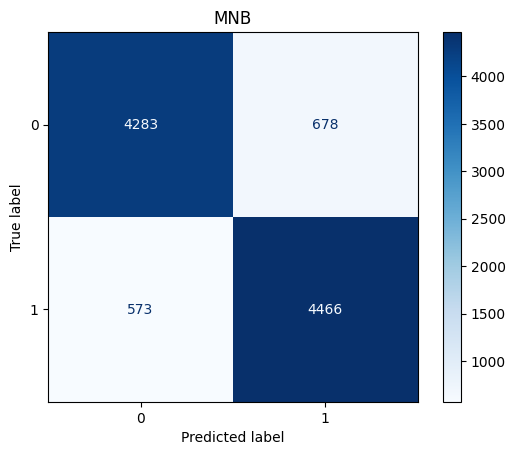

In [221]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Generate confusion matrix and display it
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap=plt.cm.Blues)

plt.title("MNB")
plt.show()

AUC Score: 0.9371362553697767
AUC Score: 0.945914229421718


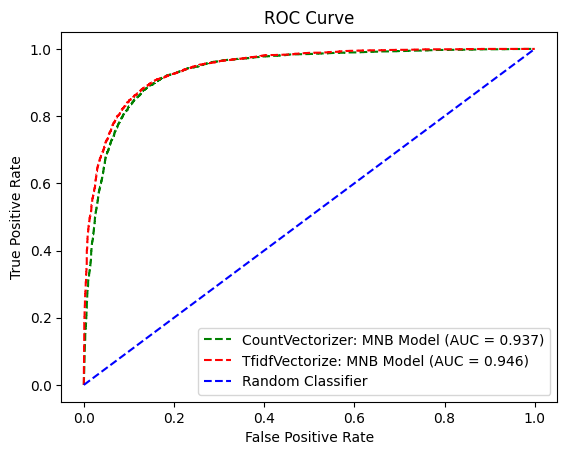

In [222]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities : CountVectorizer
MNB_prob = MNB.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, MNB_prob[:, 1], pos_label=1)

# Roc curve for tpr = fpr (random classifier)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# Compute AUC score : CountVectorizer
auc_MNB = roc_auc_score(y_test, MNB_prob[:, 1])
print("AUC Score:", auc_MNB)

# for tfidvectorizer
tfv_MNB_prob = tfv_MNB.predict_proba(X_test_tfv)
tfv_fpr, tfv_tpr, tfv_thresh = roc_curve(y_test_tfv, tfv_MNB_prob[:, 1], pos_label=1)

tfv_auc_MNB = roc_auc_score(y_test_tfv, tfv_MNB_prob[:, 1])
print("AUC Score:", tfv_auc_MNB)

# Plot ROC curve
plt.plot(fpr, tpr, linestyle='--', color='green', label='CountVectorizer: MNB Model (AUC = {:.3f})'.format(auc_MNB))
plt.plot(tfv_fpr, tfv_tpr, linestyle='--', color='red', label='TfidfVectorize: MNB Model (AUC = {:.3f})'.format(tfv_auc_MNB))

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The MNB Model's green curve hugs the top-left, indicating excellent performance with an impressive AUC of 0.927. This signifies it's far superior at distinguishing sentiments compared to a random guesser.

### Saving the Model and Loading for Inference

We need to save both the **trained model** and the **CountVectorizer**, since any new text we want to predict must go through the same transformation process as the training data.

In [223]:
import pickle

# Save the CountVectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(cv, f)

# Save the Multinomial Naive Bayes model
with open("mnb_model.pkl", "wb") as f:
    pickle.dump(MNB, f)

Now, we load the saved model and vectorizer, preprocess the unseen new text exactly as we did before, and then use the model to predict its sentiment.

In [224]:
# Load the vectorizer and model
with open("vectorizer.pkl", "rb") as f:
    loaded_vectorizer = pickle.load(f)

with open("mnb_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [225]:
custom_text = "This movie was absolutely fantastic, I loved every moment!"

cleaned_custom = cleaning(custom_text)
custom_vector = loaded_vectorizer.transform([cleaned_custom])
print(cleaned_custom, custom_vector, sep="\n")

this movie was absolutely fantastic i loved every moment
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 7 stored elements and shape (1, 3189372)>
  Coords	Values
  (0, 11320)	1
  (0, 11700)	1
  (0, 1002280)	1
  (0, 1686537)	1
  (0, 1687551)	1
  (0, 1824986)	1
  (0, 1852411)	1


In [226]:
# Predict
prediction = loaded_model.predict(custom_vector)

label = "Positive" if prediction[0] == 1 else "Negative"
print(f"Sentiment: {label}")

Sentiment: Positive
